In [1]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer, Embedding, Bidirectional
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback

In [2]:
dftweets = pd.read_csv('F:/ASDRP/data/stocktwits_SPXclassified2.csv')
dftweets = dftweets.dropna()
#dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2021-01-01")]
dftweets.head()
dftweets.shape

(43184, 7)

In [3]:
dftweets.sentiment.value_counts()

0.0    26086
1.0    17098
Name: sentiment, dtype: int64

In [4]:
from sklearn.utils import resample
RANDOM_SEED = 42
bullish = dftweets[dftweets.sentiment == 1]
bearish = dftweets[dftweets.sentiment == 0 ]
bearish_downsampled = resample(bearish,
                                replace = False,
                                n_samples = len(dftweets[dftweets['sentiment'] == 1]),
                                random_state = RANDOM_SEED)
dftweets = pd.concat([bullish, bearish_downsampled])
dftweets.sentiment.value_counts()

0.0    17098
1.0    17098
Name: sentiment, dtype: int64

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(dftweets['message'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

dftweets['message'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(dftweets['message']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedcontent = tokenizer.tokenize(list(dftweets['content']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['spy', 'replace', 'all', 'american', 'engineers', 'with', 'curryboys', 'india'], ['this', 'could', 'test', '2800', 'the', 'spring', 'but', 'buying', 'opp', 'for', 'the', 'next', 'years'], ['indexes', 'close', 'with', 'some', 'gains', 'after', 'the', 'trade', 'deal', 'betweeen', 'and', 'about', 'brexit', 'terms', 'day', 'with', 'few', 'emotions', 'now', 'time', 'with', 'our', 'families', 'and', 'loved', 'ones', 'best', 'wishes', 'everyone', 'hst', 'will', 'reopen', 'next', 'week', 'keeping', 'his', 'aggressive', 'long', 'position'], ['lotto', 'added', 'spx', '3720'], ['merry', 'christmas', '900', 'followers', 'and', 'the', 'future', 'this', 'year', 'was', 'amazing', 'year', 'dig

In [6]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
  stringcontent = ""
  for j in i:
    stringcontent += lemmatizer.lemmatize(j) + " " 
  
  newcontent.append(stringcontent)
dftweets['Content'] = newcontent

In [7]:
dftweets

,Unnamed: 0,symbol,message,datetime,user,message_id,sentiment,Content
14,15,SPX,spy replace all american engineers with curryb...,2020-12-24T21:31:17Z,1705039,267209000,1.0,spy replace all american engineer with currybo...
28,29,SPX,this could test 2800 the spring but buying opp...,2020-12-24T19:14:17Z,1902914,267188014,1.0,this could test 2800 the spring but buying opp...
32,33,SPX,indexes close with some gains after the trade ...,2020-12-24T18:53:50Z,2084625,267183905,1.0,index close with some gain after the trade dea...
33,34,SPX,lotto added spx 3720,2020-12-24T18:29:22Z,1092817,267178398,1.0,lotto added spx 3720
35,36,SPX,merry christmas 900 followers and the future t...,2020-12-24T18:27:21Z,2175262,267177890,1.0,merry christmas 900 follower and the future th...
...,...,...,...,...,...,...,...,...
159638,159639,SPX,head and shoulders downslide this should conti...,2019-03-06T20:15:41Z,1241781,156044247,0.0,head and shoulder downslide this should contin...
106858,106859,SPX,madness will end madness phase one trade deal ...,2019-12-12T20:03:50Z,2869290,186746931,0.0,madness will end madness phase one trade deal ...
153103,153104,SPX,reached for hedge position short now,2019-04-01T17:11:30Z,683186,159107452,0.0,reached for hedge position short now
44756,44757,SPX,this halloween,2020-06-30T16:39:29Z,2197536,224233282,0.0,this halloween


In [8]:
epochs = 10
embed_size = 200
batch_size = 16
maxlen = 75
vocab_size = 35000

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
EMBEDDING_FILE = 'F:/ASDRP/src/models/textclassification/glove.twitter.27B.200d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8" ))

In [11]:
from sklearn.model_selection import train_test_split
X = dftweets.Content.values 
y = dftweets.sentiment.values
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen = maxlen)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) + 1
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i > vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [13]:
embedding_matrix.shape

(23329, 200)

In [14]:
class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [15]:
epochs = 10
embed_size = 200
batch_size = 16

In [16]:
model = Sequential()
model.add(Embedding(nb_words, output_dim=embed_size, input_length= 200, weights = [embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(units=128)))
#model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [17]:
my_callback = MyThresholdCallback(threshold=0.75)
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test, y_test) , epochs = epochs, callbacks = [my_callback])

Epoch 1/10
1497/1497 [==============================] - 85s 54ms/step - loss: 0.6509 - tp: 3879.9005 - fp: 2322.1789 - tn: 3656.0888 - fn: 2133.8011 - accuracy: 0.6127 - precision: 0.6095 - recall: 0.6390 - auc: 0.6598 - val_loss: 0.5869 - val_tp: 3195.0000 - val_fp: 1337.0000 - val_tn: 3817.0000 - val_fn: 1910.0000 - val_accuracy: 0.6835 - val_precision: 0.7050 - val_recall: 0.6259 - val_auc: 0.7525
Epoch 2/10
1497/1497 [==============================] - 86s 57ms/step - loss: 0.5621 - tp: 4132.7964 - fp: 1650.7690 - tn: 4331.4306 - fn: 1876.9733 - accuracy: 0.7055 - precision: 0.7166 - recall: 0.6807 - auc: 0.7790 - val_loss: 0.5704 - val_tp: 4040.0000 - val_fp: 2026.0000 - val_tn: 3128.0000 - val_fn: 1065.0000 - val_accuracy: 0.6987 - val_precision: 0.6660 - val_recall: 0.7914 - val_auc: 0.7833
Epoch 3/10
1497/1497 [==============================] - 80s 53ms/step - loss: 0.4940 - tp: 4508.5688 - fp: 1434.1028 - tn: 4543.0320 - fn: 1506.2657 - accuracy: 0.7551 - precision: 0.7576 - re

In [18]:
model.save('modelGLOVE7331.h5')

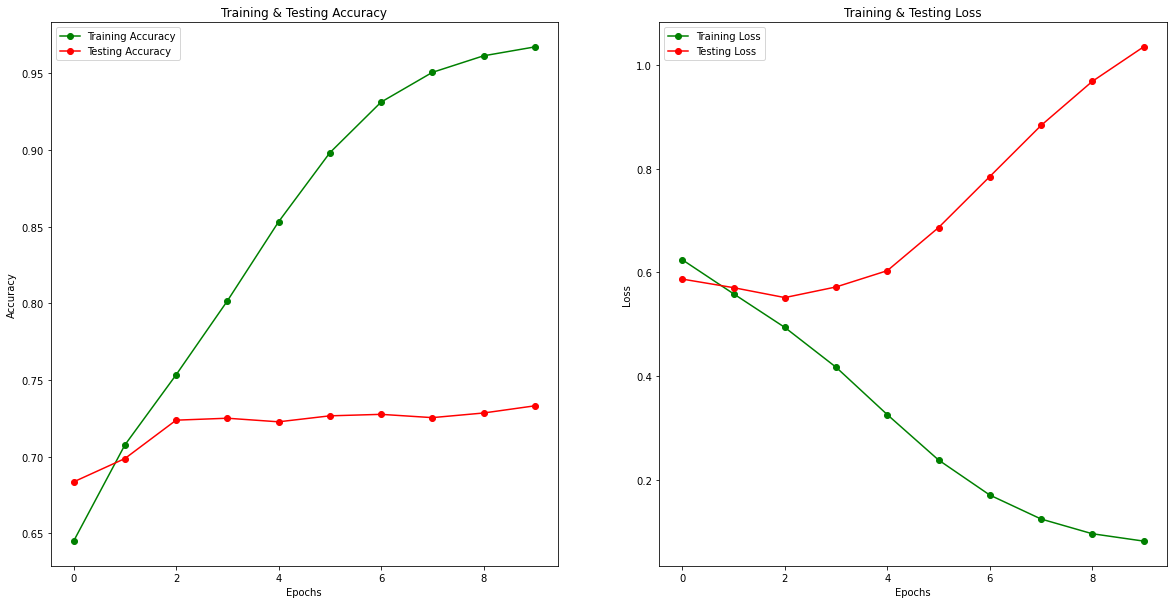

In [19]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          4665800   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 5,002,953
Trainable params: 337,153
Non-trainable params: 4,665,800
_________________________________________________________________


In [21]:
predicted = (model.predict(X_test) >= 0.5).astype("int")

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74      5154
         1.0       0.75      0.70      0.72      5105

    accuracy                           0.73     10259
   macro avg       0.73      0.73      0.73     10259
weighted avg       0.73      0.73      0.73     10259



<AxesSubplot:>

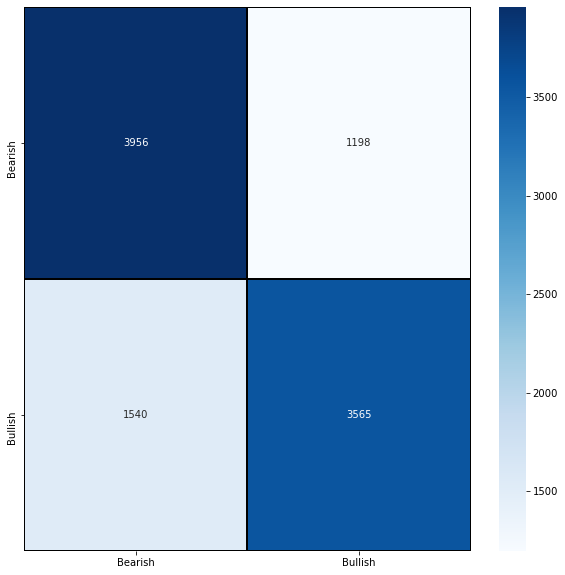

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predicted)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['Bearish','Bullish'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bearish','Bullish'] , yticklabels = ['Bearish','Bullish'])

In [175]:
xna = pd.read_csv('F:/ASDRP/data/stocktwits_SPXclassified.csv')
xna = xna[xna['sentiment'].isna()]

In [178]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

#word_vectors = w2v_model.wv

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(xna['message'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

xna['Content'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(xna['Content']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedcontent = tokenizer.tokenize(list(dftweets['content']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
    stringcontent = ""
    for j in i:
        stringcontent += lemmatizer.lemmatize(j) + " "
    newcontent.append(stringcontent)
xna['Content'] = newcontent

X2 = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in xna["Content"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X2.append(tmp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['looking', 'for', 'more', 'green', 'tomorrow', 'but', 'could', 'weak', 'pop', 'get', 'closer', 'quad', 'witching', 'day', 'all', 'all', 'pretty', 'great', 'day', 'hope', 'you', 'all', 'made', 'some', 'nice', 'profits'], ['all', 'about', 'fomc', 'and', 'stimulus', 'lower', 'rates', 'for', 'longer', 'fomc', 'stays', 'rates', 'and', 'keeps', 'asset', 'buy', 'programs', 'place', 'congress', 'moving', 'quickly', 'aid', 'details', '700', 'direct', 'checks', 'excess', 'ins', 'more', 'ppp', 'help', 'smbiz', 'stocks', 'move', 'new', 'athighs'], ['500', 'stocks', 'day', 'high', 'dec', 'day', 'day', 'day', 'indexindicators', 'com'], ['the', 'fed', 'summary', 'economic', 'projections', 'of

In [179]:
t = Tokenizer()
t.fit_on_texts(X2)

X2 = t.texts_to_sequences(X2)
X2 = pad_sequences(X2, maxlen=maxlen)